<a href="https://colab.research.google.com/github/ArthAgrawal/Audio-Forensics-Research/blob/main/AF_Test4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt

directories = {
    'Bonafide': '/content/drive/MyDrive/LA_Dataset_Final/Bonafide',
    'Spoof-A01': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A01',
    'Spoof-A02': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A02',
    'Spoof-A03': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A03',
    'Spoof-A04': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A04',
    'Spoof-A05': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A05',
    'Spoof-A06': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A06',
}

In [3]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
!pip install audiomentations


In [ ]:
import os
import numpy as np
from tqdm import tqdm
import librosa
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# Define audio augmentation pipeline
audio_augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),  # Adjusted argument names
])

# Function to apply audio augmentations
def augment_audio(y, sr):
    """
    Applies the defined augmentations to the audio signal.

    Args:
        y (np.ndarray): Audio signal.
        sr (int): Sampling rate.

    Returns:
        np.ndarray: Augmented audio signal.
    """
    augmented_y = audio_augmentations(samples=y, sample_rate=sr)
    print("Augmentations applied.")  # Log a message indicating that augmentations were applied
    return augmented_y


# Converting audio to Mel spectrogram
def audio_to_mel_spectrogram(file_path, sr=11000, n_mels=256, max_time_frames=256, apply_augmentation=True):
    """
    Converts an audio file to a Mel spectrogram with optional augmentations.

    Args:
        file_path (str): Path to the audio file.
        sr (int): Sampling rate.
        n_mels (int): Number of Mel bands.
        max_time_frames (int): Maximum time frames for spectrogram.
        apply_augmentation (bool): Whether to apply augmentations.

    Returns:
        np.ndarray or None: Mel spectrogram or None if processing fails.
    """
    try:
        y, original_sr = librosa.load(file_path, sr=sr)  # Load audio with target sampling rate

        # Apply augmentations if specified
        if apply_augmentation:
            y = augment_audio(y, sr)

        # Compute Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to dB scale

        # Truncate or pad to max_time_frames
        if mel_spectrogram.shape[1] > max_time_frames:
            mel_spectrogram = mel_spectrogram[:, :max_time_frames]
        else:
            pad_width = max_time_frames - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')

        return mel_spectrogram
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Load data from both the original and new 'Bonafide' directories
def load_data_from_folders(folders, labels, sr=11000, n_mels=256, max_time_frames=256, apply_augmentation=True):
    """
    Loads audio data from folders and converts them to Mel spectrograms.

    Args:
        folders (list): List of folder paths.
        labels (list): Corresponding labels for each folder.
        sr (int): Sampling rate.
        n_mels (int): Number of Mel bands.
        max_time_frames (int): Maximum time frames for spectrogram.
        apply_augmentation (bool): Whether to apply augmentations.

    Returns:
        tuple: (Feature array, label array)
    """
    X, y = [], []
    for folder, label in zip(folders, labels):
        print(f"Processing {folder}...")
        files = os.listdir(folder)

        for file in tqdm(files):
            file_path = os.path.join(folder, file)
            mel_spectrogram = audio_to_mel_spectrogram(
                file_path, sr, n_mels, max_time_frames, apply_augmentation
            )
            if mel_spectrogram is not None:
                X.append(mel_spectrogram)
                y.append(label)
    return np.array(X), np.array(y)

# Define dataset structure for combining both directories
bonafide_folder = '/content/drive/MyDrive/LA_Dataset_Final/Bonafide'
new_real_audio_folder = '/content/drive/MyDrive/asvpoof_data/real'  # Path to the new real audio files
spoof_base_folder = '/content/drive/MyDrive/LA_Dataset_Final/Spoof'
spoof_classes = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06']

# Combine both Bonafide folders
folders = [bonafide_folder, new_real_audio_folder] + [
    os.path.join(spoof_base_folder, spoof_class) for spoof_class in spoof_classes
]
labels = [0] + [0] + [i + 1 for i in range(len(spoof_classes))]  # Bonafide=0, New Real=0, Spoof A01=1, A02=2, ...

# Process the data
X, y = load_data_from_folders(folders, labels)

print(f"Loaded {len(X)} samples.")
print(f"Shape of feature data: {X.shape}, Shape of labels: {y.shape}")


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize each spectrogram independently to preserve spatial relationships
scaler = MinMaxScaler()
X_normalized = np.array([scaler.fit_transform(img) for img in X])

X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Reshaping for CNN input (Adding a channel dimension)
X_train = X_train[..., np.newaxis]  # Channel = 1 as Mel Spectrograms are greyscale
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Final input shape (for CNN): {X_train.shape}, {X_val.shape}, {X_test.shape}")


Training set shape: (18820, 256, 256), (18820,)
Validation set shape: (4033, 256, 256), (4033,)
Test set shape: (4034, 256, 256), (4034,)
Final input shape (for CNN): (18820, 256, 256, 1), (4033, 256, 256, 1), (4034, 256, 256, 1)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Reshape,
    LSTM,
    BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_stronger_cnn_lstm_model_v2(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CNN Layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Reshape for LSTM
    x = Reshape((x.shape[1], -1))(x)

    # LSTM Layers
    x = LSTM(512, return_sequences=True, dropout=0.3)(x)  # Increased LSTM units
    x = LSTM(256, dropout=0.3)(x)  # Increased LSTM units

    # Fully Connected Layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Increased neurons
    x = Dropout(0.5)(x)  # Increased dropout for regularization
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Increased dropout

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define input shape and number of classes
input_shape = (256, 256, 1)  # Replace with your dataset's input shape
num_classes = 7  # Replace with the number of classes in your dataset

# Build the model
model = build_stronger_cnn_lstm_model_v2(input_shape, num_classes)

# Compile the model with AdamW optimizer
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 8192)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16, 512)             │      17,827,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,433,671 (77.95 MB)

 Trainable params: 20,431,751 (77.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set up Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, lr_reduction]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 61s 83ms/step - accuracy: 0.2015 - loss: 12.5482 - val_accuracy: 0.1421 - val_loss: 8.0512 - learning_rate: 1.0000e-04
Epoch 2/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.3699 - loss: 5.9589 - val_accuracy: 0.4595 - val_loss: 3.9442 - learning_rate: 1.0000e-04
Epoch 3/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.6122 - loss: 3.1176 - val_accuracy: 0.6281 - val_loss: 2.3848 - learning_rate: 1.0000e-04
Epoch 4/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.7320 - loss: 1.9784 - val_accuracy: 0.7543 - val_loss: 1.6209 - learning_rate: 1.0000e-04
Epoch 5/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.7939 - loss: 1.4291 - val_accuracy: 0.6397 - val_loss: 1.7120 - learning_rate: 1.0000e-04
Epoch 6/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - accuracy: 0.8218 - loss: 1.1387 - val_accuracy: 0.6219 - val_loss: 1.7506 - learning_rate: 1.0000e-04
Epoch 7/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/st

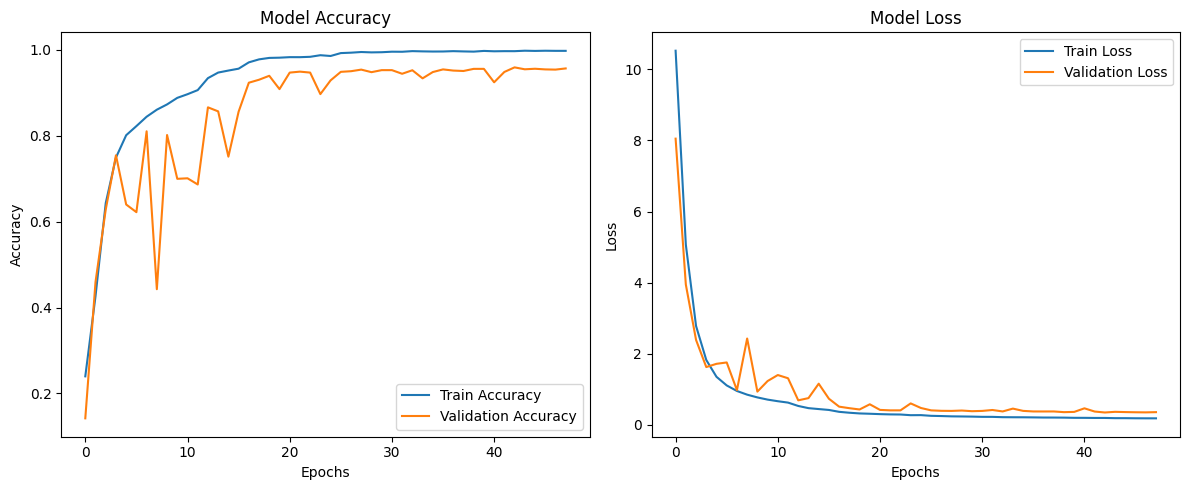

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

127/127 - 2s - 16ms/step - accuracy: 0.9606 - loss: 0.3283
Test Loss: 0.3283
Test Accuracy: 0.9606
Final Accuracy of the model: 96.06%
127/127 - 3s - 21ms/step
Sample Predictions:
True Labels: [3 0 3 5 1 2 3 3 1 6]
Predicted Labels: [3 0 3 5 1 2 3 3 1 6]


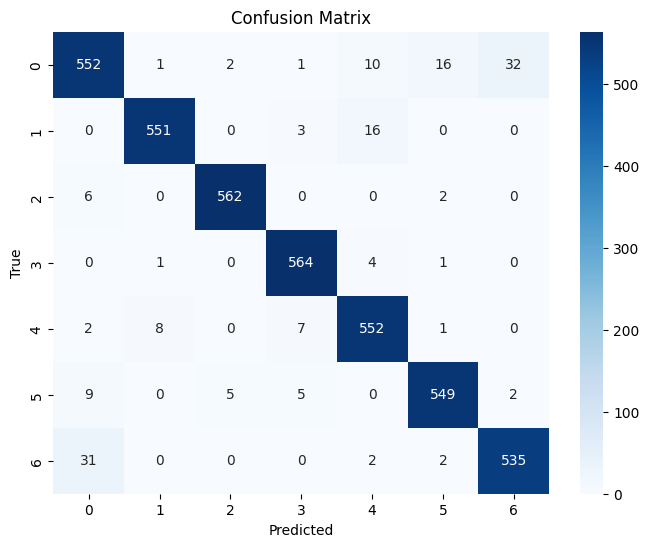

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# No need to one-hot encode since you're using sparse_categorical_crossentropy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Final Accuracy of the model: {test_accuracy * 100:.2f}%")

predictions = model.predict(X_test, verbose=2)
predicted_classes = predictions.argmax(axis=1)

# Comparing predictions with true labels
true_classes = y_test
print("Sample Predictions:")
print(f"True Labels: {true_classes[:10]}")
print(f"Predicted Labels: {predicted_classes[:10]}")

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [12]:
# Saving the model in H5 format
model.save('/content/drive/MyDrive/Audio_Forensics_Models/test5.h5')
print("Model saved")

Model saved


In [13]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Class names: 'Bonafide' is class 0, and the spoof classes are A01 to A06
class_names = ['Bonafide', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06']

model_path = '/content/drive/MyDrive/Audio_Forensics_Models/test5.h5'
model = tf.keras.models.load_model(model_path)

# Preprocess the audio file (convert to Mel spectrogram and normalize)
def preprocess_audio(file_path, sr=11000, n_mels=256, max_time_frames=256):
    mel_spectrogram = audio_to_mel_spectrogram(file_path, sr, n_mels, max_time_frames)

    if mel_spectrogram is not None:
        # Normalize the spectrogram
        scaler = MinMaxScaler()
        mel_spectrogram_normalized = scaler.fit_transform(mel_spectrogram)

        # Reshape for CNN input (Add the channel dimension)
        mel_spectrogram_normalized = mel_spectrogram_normalized[..., np.newaxis]  # Channel = 1

        return mel_spectrogram_normalized
    else:
        return None

# Function to predict the class of an audio file
def predict_audio_class(file_path):
    # Preprocess the audio file
    mel_spectrogram = preprocess_audio(file_path)

    if mel_spectrogram is not None:
        # Make prediction using the loaded model
        mel_spectrogram = np.expand_dims(mel_spectrogram, axis=0)  # Add batch dimension
        prediction = model.predict(mel_spectrogram)

        # Get the predicted class index
        predicted_class_idx = np.argmax(prediction, axis=1)[0]

        # Get the class name based on the predicted index
        predicted_class = class_names[predicted_class_idx]

        print(f"Predicted class: {predicted_class}")
        return predicted_class
    else:
        print("Error processing audio file.")
        return None


# Example usage: Predict the class of a new audio file
file_path = '/content/drive/MyDrive/LA_Dataset_Final/Bonafide/LA_T_1607779.flac'  # Replace with the path to the audio file you want to predict
predicted_class = predict_audio_class(file_path)


Augmentations applied.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Predicted class: Bonafide


In [21]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from google.colab import files  # For file upload in Google Colab

# Class names: 'Bonafide' is class 0, and the spoof classes are A01 to A06
class_names = ['Bonafide', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06']

# Load the model
model_path = '/content/drive/MyDrive/Audio_Forensics_Models/test5.h5'
model = tf.keras.models.load_model(model_path)

# Preprocess the audio file (convert to Mel spectrogram and normalize)
def preprocess_audio(file_path, sr=11000, n_mels=256, max_time_frames=256):
    mel_spectrogram = audio_to_mel_spectrogram(file_path, sr, n_mels, max_time_frames)

    if mel_spectrogram is not None:
        # Normalize the spectrogram
        scaler = MinMaxScaler()
        mel_spectrogram_normalized = scaler.fit_transform(mel_spectrogram)

        # Reshape for CNN input (Add the channel dimension)
        mel_spectrogram_normalized = mel_spectrogram_normalized[..., np.newaxis]  # Channel = 1

        return mel_spectrogram_normalized
    else:
        return None

# Function to predict the class of an audio file
def predict_audio_class(file_path):
    # Preprocess the audio file
    mel_spectrogram = preprocess_audio(file_path)

    if mel_spectrogram is not None:
        # Make prediction using the loaded model
        mel_spectrogram = np.expand_dims(mel_spectrogram, axis=0)  # Add batch dimension
        prediction = model.predict(mel_spectrogram)

        # Get the predicted class index
        predicted_class_idx = np.argmax(prediction, axis=1)[0]

        # Get the class name based on the predicted index
        predicted_class = class_names[predicted_class_idx]

        print(f"Predicted class: {predicted_class}")
        return predicted_class
    else:
        print("Error processing audio file.")
        return None

# Upload file from the local system
def upload_audio_file():
    uploaded = files.upload()  # File upload widget
    if uploaded:
        # Get the uploaded file path
        file_name = next(iter(uploaded))
        print(f"Uploaded file: {file_name}")
        return file_name
    else:
        print("No file uploaded.")
        return None

# Example usage: Upload the file and predict its class
uploaded_file_path = upload_audio_file()  # Upload an audio file from your local computer

if uploaded_file_path:
    predicted_class = predict_audio_class(uploaded_file_path)


Saving Record (online-voice-recorder.com) (5).mp3 to Record (online-voice-recorder.com) (5).mp3
Uploaded file: Record (online-voice-recorder.com) (5).mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
Predicted class: Bonafide
